# Filter Example

This example demonstrates the connection between MKS and signal
processing for a 1D filter. It shows that the filter is in fact the
same as the influence coefficients and, thus, applying the `predict`
method provided by the `MKSRegressionModel` is in essence just applying a filter.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

Here we construct a filter, $F$, such that

$$F\left(x\right) = e^{-|x|} \cos{\left(2\pi x\right)} $$

We want to show that if $F$ is used to generate sample calibration
data for the MKS, then the calculated influence coefficients are in
fact just $F$.

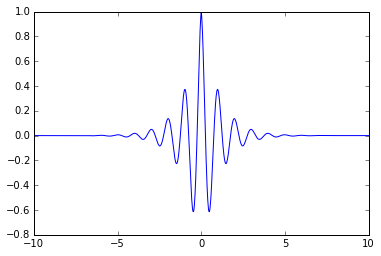

In [2]:
x0 = -10.
x1 = 10.
x = np.linspace(x0, x1, 1000)
def F(x):
    return np.exp(-abs(x)) * np.cos(2 * np.pi * x)
p = plt.plot(x, F(x))

Next we generate the sample data `(X, y)` using
`scipy.ndimage.convolve`. This performs the convolution

$$ p\left[ i \right] = F\left[j\right] X\left[i - j\right] $$

for each sample.

In [3]:
import scipy.ndimage

Nspace = 101
Nsample = 50
np.random.seed(201)
x = np.linspace(x0, x1, Nspace)
X = np.random.random((Nsample, Nspace))
y = np.array([scipy.ndimage.convolve(xx, F(x), mode='wrap') for xx in X])

For this problem, a basis is unnecessary as no discretization is
required in order to reproduce the convolution with the MKS.  Using
the `ContinuousIndicatorBasis` with `n_states=2` is the equivalent of a
non-discretized convolution in space.

In [4]:
from pymks import MKSRegressionModel
from pymks import ContinuousIndicatorBasis

basis = ContinuousIndicatorBasis(n_states=2, domain=[0, 1])
model = MKSRegressionModel(basis=basis)

Fit the model using the data generated by $F$.

In [5]:
model.fit(X, y)

To check for internal consistency, we can compare the predicted
output with the original for a few values

In [6]:
y_pred = model.predict(X)
print y[0, :4]
print y_pred[0, :4]

[-0.41059557  0.20004566  0.61200171  0.5878077 ]
[-0.41059557  0.20004566  0.61200171  0.5878077 ]


With a slight linear manipulation of the coefficients, they agree perfectly with the shape of the filter, $F$. 

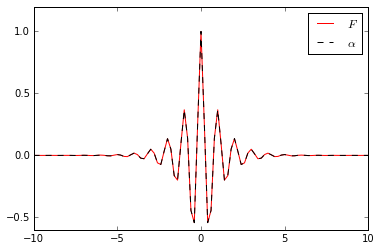

In [7]:
plt.plot(x, F(x), 'r', label=r'$F$')
plt.plot(x, -model.coeff[:,0] + model.coeff[:, 1], 'k--', label=r'$\alpha$')
l = plt.legend()

Some manipulation of the coefficients is required to reproduce the filter. Remember the convolution for the MKS is

$$ p \left[i\right] = \sum_h^{n-1} \alpha_h \left[j\right] m_h \left[i - j\right] $$

However, the `MKSRegressionModel` solves a modified form of this. There are always redundant coefficients since

$$ \sum\limits_{h=0}^{n-1} m_h \left[i\right] = 1 $$

Thus, the convolution must be rewritten taking this into account. We can rewrite the convolution as

$$ \begin{split}
p \left[i\right] &= \sum\limits_{h=0}^n \alpha_h \left[j\right] m_h \left[i - j\right] \\
        &= \sum\limits_{h=0}^{n - 2}  \alpha_h \left[j\right] m_h \left[i - j\right] + 
           \alpha_{n-1} \left[j\right] \left( I\left[i - j\right] - \sum\limits_{h=0}^{n - 2} m_h \left[i - j\right] \right) \\
        &=  \alpha_{n - 1} \left[ j \right]  I\left[i - j\right] +
           \sum\limits_{h=0}^{n - 2} \left(\alpha_h\left[j\right] - \alpha_{n-1}\left[j\right] \right) m_h\left[i - j\right] \\
        &= \beta + \sum\limits_{h=0}^{n - 2} b_h \left[ j \right] m_h \left[ i - j \right] 
\end{split}$$

where $\beta = \alpha_{n - 1} \left[ j \right]  I\left[i - j\right]$ is just a constant and $I\left[i\right] = 1$ for all $i$.
This removes the redundancies from the regression. Manipulation of the $\beta$ and $b_0$ demonstrate that the filter is reproduced.